<a href="https://colab.research.google.com/github/Bagavathiraj655/eyediseaseprediction/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
dataset_path = "/content/drive/MyDrive/Dataset "
print("Dataset folders:", os.listdir(dataset_path))

Dataset folders: ['Cataract.img', 'Glaucoma.img', 'Normal.img']


In [ ]:
def get_dataset_info(dataset_path):
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    data_info = []

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        num_images = sum(1 for f in os.scandir(category_path) if f.is_file())
        data_info.append({'Category': category, 'Number of Images': num_images})

    df = pd.DataFrame(data_info)
    print("\nDataset Information:")
    print(df.to_string(index=False))
    return df

get_dataset_info(dataset_path)


Dataset Information:
    Category  Number of Images
Cataract.img              1038
Glaucoma.img              1007
  Normal.img              1074


,Category,Number of Images
0,Cataract.img,1038
1,Glaucoma.img,1007
2,Normal.img,1074


In [ ]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduced rotation for better stability
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,  # Reduced zoom
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
train_generator = data_gen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training'
)
val_generator = data_gen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation'
)

Found 2497 images belonging to 3 classes.
Found 622 images belonging to 3 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers[-5:]:  # Unfreezing last 5 layers
    layer.trainable = True


In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.4),  # Reduced Dropout for more learning
    Dense(len(train_generator.class_indices), activation='softmax')
])

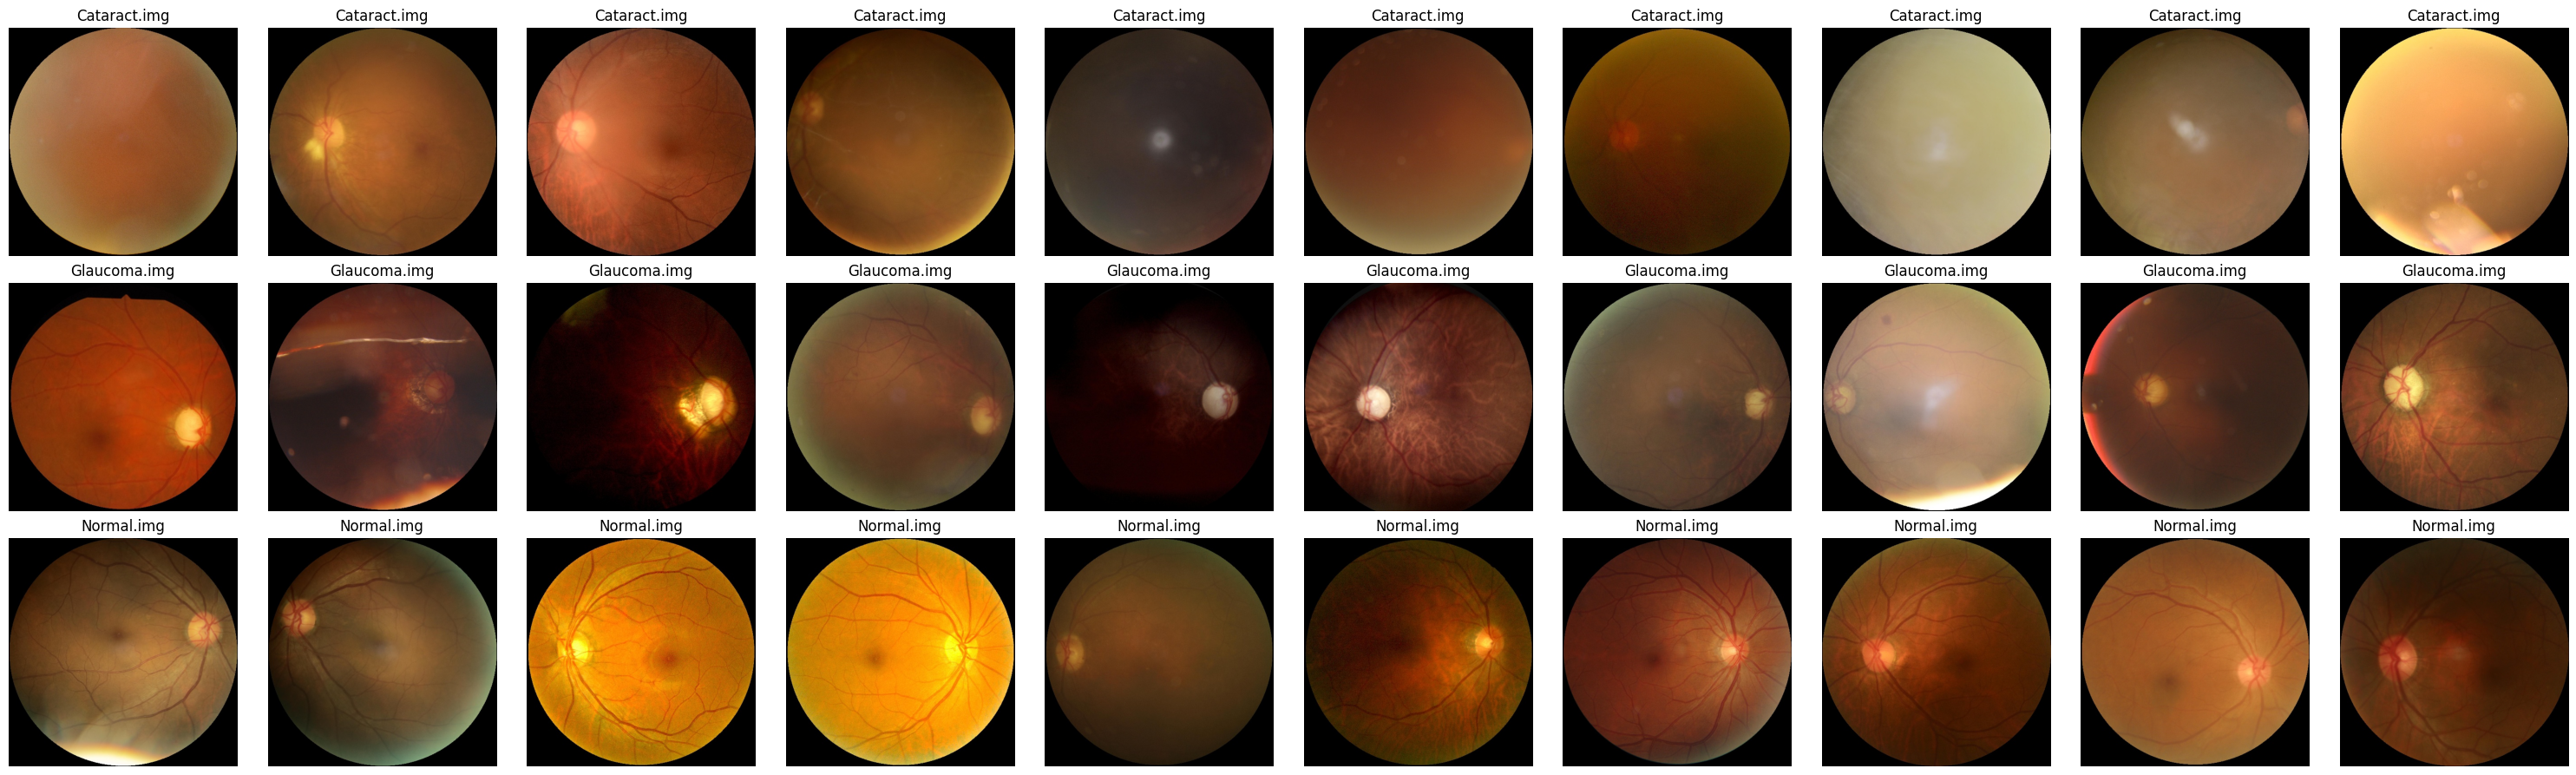

In [ ]:
def show_dataset_images(dataset_path, num_images=10):
    categories = os.listdir(dataset_path)
    fig, axes = plt.subplots(len(categories), num_images, figsize=(num_images * 3, len(categories) * 3))

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)[:num_images]

        for j, image_name in enumerate(images):
            img_path = os.path.join(category_path, image_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(category)

    plt.tight_layout()
    plt.show()

show_dataset_images(dataset_path)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    callbacks=[lr_scheduler]
)

Epoch 1/4
79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8261 - loss: 0.4225 - val_accuracy: 0.3441 - val_loss: 8.2752 - learning_rate: 1.0000e-04
Epoch 2/4
79/79 ━━━━━━━━━━━━━━━━━━━━ 78s 980ms/step - accuracy: 0.8412 - loss: 0.4036 - val_accuracy: 0.6077 - val_loss: 1.5483 - learning_rate: 1.0000e-04
Epoch 3/4
79/79 ━━━━━━━━━━━━━━━━━━━━ 78s 981ms/step - accuracy: 0.8656 - loss: 0.3360 - val_accuracy: 0.4936 - val_loss: 1.7081 - learning_rate: 1.0000e-04
Epoch 4/4
79/79 ━━━━━━━━━━━━━━━━━━━━ 77s 971ms/step - accuracy: 0.8869 - loss: 0.2953 - val_accuracy: 0.6109 - val_loss: 3.5337 - learning_rate: 1.0000e-04


In [ ]:
model.save("/content/drive/MyDrive/eye_disease_model.h5")


In [ ]:
final_train_acc = history.history['accuracy'][-1] * 100
final_val_acc = history.history['val_accuracy'][-1] * 100
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


Final Training Accuracy: 88.43%
Final Validation Accuracy: 61.09%


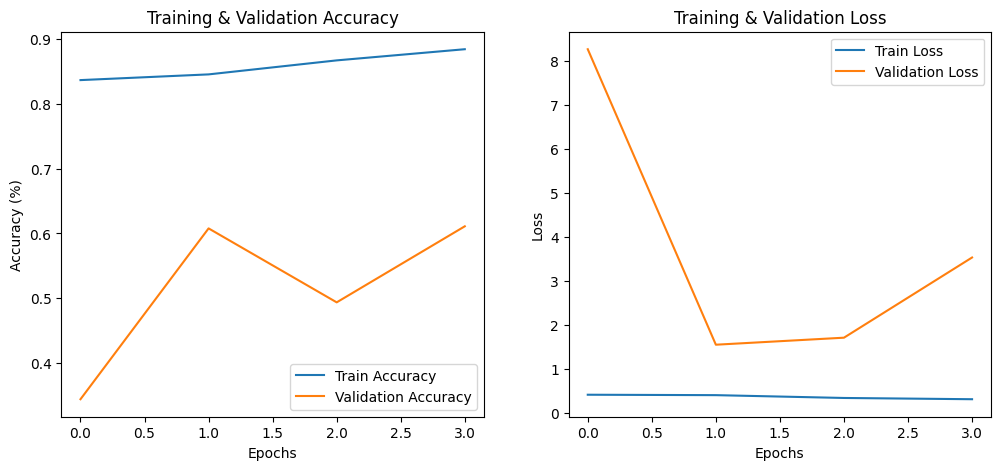

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 532ms/step


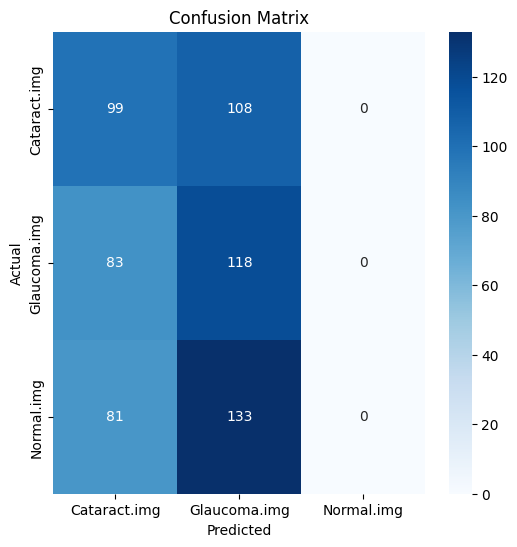

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_image(image_path):
    if not os.path.exists(image_path):
        print("Image path not found.")
        return

    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_indices = train_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[np.argmax(prediction)]

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


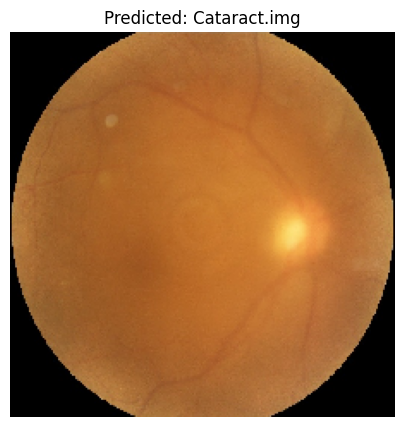

Predicted Class: Cataract.img


In [ ]:
image_path = "/content/drive/MyDrive/Dataset /Cataract.img/1084_right.jpg"
result = predict_image(image_path)
print("Predicted Class:", result)
